In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from Dilated_Conv_Att import AttDiCEm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('../Datasets'))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataset_creator_feature_eng import StockDataset

In [3]:
base_path = "../price/raw"
df = pd.read_csv(f"{base_path}/AAPL.csv")
print(len(df))

1258


In [4]:
# 1. Daily Return (percentage change from open to close)
df['Return'] = (df['Close'] - df['Open']) / df['Open']

# 2. Price Difference (Close - Open)
df['Diff'] = df['Close'] - df['Open']

# 3. High-Low Difference (as a measure of volatility)
df['HL_Diff'] = df['High'] - df['Low']

# 4. 5-day Moving Average of the Close (shifted to avoid leakage)
df['MA5'] = df['Close'].rolling(window=5).mean().shift(1)

# 5. 5-day Moving Average of the Return (shifted)
df['Return_MA5'] = df['Return'].rolling(window=5).mean().shift(1)

# Drop rows with NaN values that result from rolling and shifting
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Diff,HL_Diff,MA5,Return_MA5
0,2012-09-11,95.015717,95.728569,93.785713,94.370003,85.265068,125995800,-0.006796,-0.645714,1.942856,96.132857,-0.002394
1,2012-09-12,95.264282,95.699997,93.714287,95.684288,86.452538,178058300,0.004409,0.420006,1.985710,95.722000,-0.006519
2,2012-09-13,96.767143,97.928574,96.395714,97.568573,88.155037,149590000,0.008282,0.801430,1.532860,95.709428,-0.004057
3,2012-09-14,98.565712,99.568573,98.269997,98.754288,89.226341,150118500,0.001913,0.188576,1.298576,95.901143,-0.003321
4,2012-09-17,99.907143,99.971428,99.230003,99.968575,90.323479,99507800,0.000615,0.061432,0.741425,96.210858,-0.003644


In [6]:
feature_columns = ['Open', 'High', 'Low', 'Volume', 'Return', 'Diff', 'HL_Diff', 'MA5', 'Return_MA5']
feature_columns = ['Volume', 'Return', 'Diff', 'HL_Diff', 'MA5', 'Return_MA5']
# We keep the target as the raw 'Close' (normalized later)
target_column = 'Close'

filtered_df = df[feature_columns + [target_column]]

seq_len = 10

train_size = int(len(filtered_df) * 0.8)
train_data = filtered_df.iloc[:train_size].copy()
test_data = filtered_df.iloc[train_size:].copy()


In [7]:
train_data.head()

,Volume,Return,Diff,HL_Diff,MA5,Return_MA5,Close
0,125995800,-0.006796,-0.645714,1.942856,96.132857,-0.002394,94.370003
1,178058300,0.004409,0.420006,1.985710,95.722000,-0.006519,95.684288
2,149590000,0.008282,0.801430,1.532860,95.709428,-0.004057,97.568573
3,150118500,0.001913,0.188576,1.298576,95.901143,-0.003321,98.754288
4,99507800,0.000615,0.061432,0.741425,96.210858,-0.003644,99.968575


In [8]:
scaler = MinMaxScaler()
scaler.fit(train_data)

# Transform train and test sets (first fit on the training data and then apply transform to train and test to avoid dta leakage).
train_data.loc[:, train_data.columns] = scaler.transform(train_data)
test_data.loc[:, test_data.columns] = scaler.transform(test_data)


/tmp/ipykernel_5257/4147713395.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.32072709 0.46856191 0.38772434 ... 0.0471822  0.03877453 0.03906133]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.loc[:, train_data.columns] = scaler.transform(train_data)
/tmp/ipykernel_5257/4147713395.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.03928253  0.08325006  0.1134565   0.0951555   0.09156573  0.13950723
  0.27782951  0.21846813  0.1897979   0.09647874  0.06095948  0.06518731
  0.05119053  0.11197765  0.04776999  0.0328282   0.04712172  0.06485735
  0.0662547   0.02457757  0.04739346  0.02387137  0.04467458  0.03212115
  0.06584836  0.14480245  0.06968404  0.06288499  0.06419062  0.03003833
  0.03267515  0.01984344  0.03146067  0.02881107  0.02979356  0.0996193
  0.15074622  0.061094

In [9]:
train_data.head()

,Volume,Return,Diff,HL_Diff,MA5,Return_MA5,Close
0,0.320727,0.388376,0.430492,0.090750,0.526333,0.513185,0.499676
1,0.468562,0.461470,0.498720,0.093373,0.520826,0.406357,0.516698
2,0.387724,0.486737,0.523139,0.065659,0.520657,0.470119,0.541103
3,0.389225,0.445189,0.483904,0.051320,0.523227,0.489160,0.556460
4,0.245513,0.436720,0.475764,0.017223,0.527378,0.480815,0.572187


In [10]:

train_dataset = StockDataset(train_data, seq_len, feature_columns, target_column=target_column)
test_dataset = StockDataset(test_data, seq_len, feature_columns, target_column=target_column)
print("Datasets created successfully!")

Datasets created successfully!


In [11]:
train_dataset[0]
# print(train_dataset[0][0].shape)

(tensor([[0.3207, 0.3884, 0.4305, 0.0908, 0.5263, 0.5132],
         [0.4686, 0.4615, 0.4987, 0.0934, 0.5208, 0.4064],
         [0.3877, 0.4867, 0.5231, 0.0657, 0.5207, 0.4701],
         [0.3892, 0.4452, 0.4839, 0.0513, 0.5232, 0.4892],
         [0.2455, 0.4367, 0.4758, 0.0172, 0.5274, 0.4808],
         [0.2281, 0.4516, 0.4904, 0.0235, 0.5416, 0.6188],
         [0.1950, 0.4499, 0.4887, 0.0105, 0.5574, 0.6690],
         [0.2019, 0.4284, 0.4676, 0.0282, 0.5698, 0.6598],
         [0.3687, 0.4112, 0.4506, 0.0218, 0.5758, 0.6135],
         [0.4171, 0.4700, 0.5078, 0.0778, 0.5792, 0.5865]]),
 tensor(0.5082))

In [12]:
test_dataset[0]

(tensor([[0.0393, 0.4206, 0.4590, 0.0202, 0.6676, 0.6465],
         [0.0833, 0.4648, 0.5058, 0.0753, 0.6700, 0.6271],
         [0.1135, 0.3275, 0.3611, 0.0961, 0.6763, 0.6428],
         [0.0952, 0.3386, 0.3752, 0.1304, 0.6748, 0.5377],
         [0.0916, 0.6100, 0.6504, 0.1671, 0.6651, 0.4342],
         [0.1395, 0.4594, 0.5000, 0.0667, 0.6590, 0.5735],
         [0.2778, 0.6151, 0.6665, 0.2430, 0.6597, 0.6043],
         [0.2185, 0.5307, 0.5813, 0.1089, 0.6688, 0.7236],
         [0.1898, 0.4214, 0.4590, 0.0998, 0.6957, 0.8849],
         [0.0965, 0.3415, 0.3688, 0.1512, 0.7273, 0.9507]]),
 tensor(0.7481))

In [13]:
test_dataset[1]

(tensor([[0.0833, 0.4648, 0.5058, 0.0753, 0.6700, 0.6271],
         [0.1135, 0.3275, 0.3611, 0.0961, 0.6763, 0.6428],
         [0.0952, 0.3386, 0.3752, 0.1304, 0.6748, 0.5377],
         [0.0916, 0.6100, 0.6504, 0.1671, 0.6651, 0.4342],
         [0.1395, 0.4594, 0.5000, 0.0667, 0.6590, 0.5735],
         [0.2778, 0.6151, 0.6665, 0.2430, 0.6597, 0.6043],
         [0.2185, 0.5307, 0.5813, 0.1089, 0.6688, 0.7236],
         [0.1898, 0.4214, 0.4590, 0.0998, 0.6957, 0.8849],
         [0.0965, 0.3415, 0.3688, 0.1512, 0.7273, 0.9507],
         [0.0610, 0.4627, 0.5051, 0.0704, 0.7492, 0.7375]]),
 tensor(0.7619))

In [17]:
from itertools import product
import numpy as np
import os

results_dir = "results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Define hyperparameter ranges
param_grid = {
    "hidden_size": [32, 64, 128],
    "kernel_size": [3, 5, 7],
    "dilation_rates": [[1,2,4], [1,2,4,8], [1,2,4,8,16]],
    "num_heads": [2, 4, 8],
    "batch_size": [8, 16, 32],
    "learning_rate": [5e-3],
    "epochs": [20]
}

# Store results
best_loss = float("inf")
best_params = None

# Iterate through all parameter combinations
for params in product(*param_grid.values()):
    # Unpack parameters
    param_dict = dict(zip(param_grid.keys(), params))
    
    print(f"Testing {param_dict}...")

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=param_dict["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=param_dict["batch_size"], shuffle=False)

    # Initialize model
    model = AttDiCEm(
        input_size=len(feature_columns),
        hidden_size=param_dict["hidden_size"],
        kernel_size=param_dict["kernel_size"],
        dilation_rates=param_dict["dilation_rates"],
        num_heads=param_dict["num_heads"]
    )

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=param_dict["learning_rate"])

    train_losses = []
    test_losses = []
    for epoch in range(param_dict["epochs"]):
        model.train()
        epoch_train_losses = []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())
        avg_train_loss = np.mean(epoch_train_losses)
        train_losses.append(avg_train_loss)
    
        # Evaluate on test set after each epoch
        model.eval()
        epoch_test_losses = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                epoch_test_losses.append(loss.item())
        avg_test_loss = np.mean(epoch_test_losses)
        test_losses.append(avg_test_loss)
    
    # Compute predictions on the entire test set
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().cpu().numpy().tolist())
            actuals.extend(targets.cpu().numpy().tolist())
        # Update best parameters based on final test loss
    if test_losses[-1] < best_loss:
        print("\n\n NEW BEST PARAMS\n\n")
        best_loss = test_losses[-1]
        best_params = param_dict
        # Plot training and test losses in the same figure
        plt.figure(figsize=(10, 6))
        epochs_range = range(1, param_dict["epochs"] + 1)
        plt.plot(epochs_range, train_losses, label="Train Loss", marker="o")
        plt.plot(epochs_range, test_losses, label="Test Loss", marker="x")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        title_loss = (f"Loss Curve (hs={param_dict['hidden_size']}, kernel={param_dict['kernel_size']}, "
                    f"dilations={param_dict['dilation_rates']}, heads={param_dict['num_heads']}, "
                    f"bs={param_dict['batch_size']}, lr={param_dict['learning_rate']})")
        plt.title(title_loss)
        plt.legend()
        loss_filename = os.path.join(
            results_dir,
            f"grid_loss_hs{param_dict['hidden_size']}_kernel{param_dict['kernel_size']}_"
            f"dil{''.join(map(str, param_dict['dilation_rates']))}_heads{param_dict['num_heads']}_"
            f"bs{param_dict['batch_size']}_lr{param_dict['learning_rate']}.png"
        )
        plt.savefig(loss_filename)
        plt.close()
        
        # Plot example predictions vs. ground truth (first 100 points)
        plt.figure(figsize=(10, 6))
        sample_range = slice(0, 100)
        plt.plot(np.array(actuals)[sample_range], label="Actual", marker="o")
        plt.plot(np.array(predictions)[sample_range], label="Predicted", marker="x")
        title_pred = (f"Prediction vs Truth (hs={param_dict['hidden_size']}, kernel={param_dict['kernel_size']}, "
                    f"dilations={param_dict['dilation_rates']}, heads={param_dict['num_heads']}, "
                    f"bs={param_dict['batch_size']}, lr={param_dict['learning_rate']})")
        plt.title(title_pred)
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend()
        pred_filename = os.path.join(
            results_dir,
            f"grid_pred_hs{param_dict['hidden_size']}_kernel{param_dict['kernel_size']}_"
            f"dil{''.join(map(str, param_dict['dilation_rates']))}_heads{param_dict['num_heads']}_"
            f"bs{param_dict['batch_size']}_lr{param_dict['learning_rate']}.png"
        )
        plt.savefig(pred_filename)
        plt.close()
        
        print(f"Saved loss and prediction plots for {param_dict}")

    
    


print("Best Hyperparameters:", best_params)

Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.005, 'epochs': 20}...


 NEW BEST PARAMS


Saved loss and prediction plots for {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.005, 'epochs': 20}
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 16, 'learning_rate': 0.005, 'epochs': 20}...
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 32, 'learning_rate': 0.005, 'epochs': 20}...
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 4, 'batch_size': 8, 'learning_rate': 0.005, 'epochs': 20}...
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 4, 'batch_size': 16, 'learning_rate': 0.005, 'epochs': 20}...
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_r

Epoch 1/100, Loss: 0.03752291575074196
Epoch 2/100, Loss: 0.001592954620718956
Epoch 3/100, Loss: 0.0014070119941607118
Epoch 4/100, Loss: 0.0019456107402220368
Epoch 5/100, Loss: 0.0018699482316151261
Epoch 6/100, Loss: 0.0010937964543700218
Epoch 7/100, Loss: 0.002465292811393738
Epoch 8/100, Loss: 0.0009589529363438487
Epoch 9/100, Loss: 0.00065453170100227
Epoch 10/100, Loss: 0.002697512973099947
Epoch 11/100, Loss: 0.0014982203720137477
Epoch 12/100, Loss: 0.0015168518293648958
Epoch 13/100, Loss: 0.0010303778108209372
Epoch 14/100, Loss: 0.0003175265446770936
Epoch 15/100, Loss: 0.0024080928415060043
Epoch 16/100, Loss: 0.004946157801896334
Epoch 17/100, Loss: 0.0006444713217206299
Epoch 18/100, Loss: 0.0009950135136023164
Epoch 19/100, Loss: 0.001453958684578538
Epoch 20/100, Loss: 0.0004669776826631278
Epoch 21/100, Loss: 0.0004653098003473133
Epoch 22/100, Loss: 0.00037144520319998264
Epoch 23/100, Loss: 0.0026294237468391657
Epoch 24/100, Loss: 0.0011525991139933467
Epoch 25/

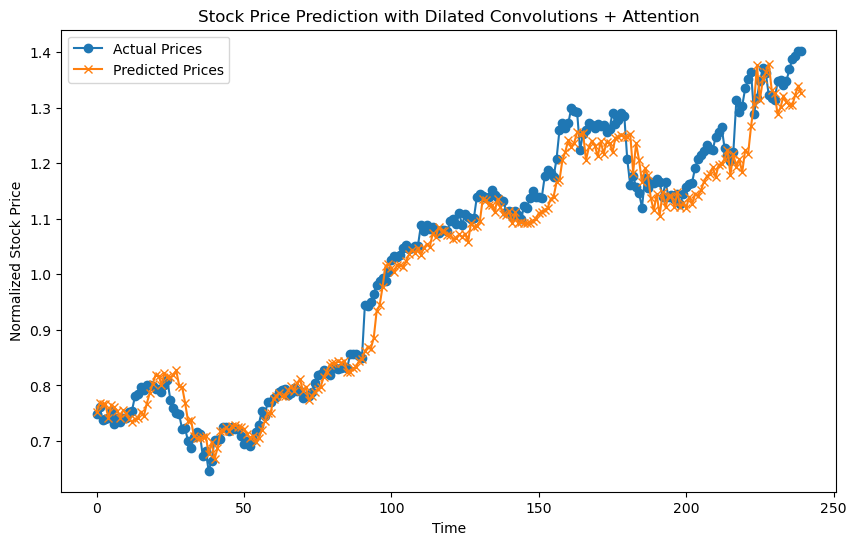

In [17]:
# Define the new model

'''
Some parameters that yielded good results from previous cell :
# Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 8, 'batch_size': 32, 'learning_rate': 0.005, 'epochs': 50}...
# Test Loss: 0.0002
# Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4, 8], 'num_heads': 8, 'batch_size': 8, 'learning_rate': 0.005, 'epochs': 50}...
# Test Loss: 0.0002

# Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 16, 'learning_rate': 0.001, 'epochs': 50}...
# Test Loss: 0.0005

#Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 8, 'batch_size': 8, 'learning_rate': 0.005, 'epochs': 50}...
# Test Loss: 0.0007
'''


input_size = len(feature_columns)  
hidden_size = 32 
kernel_size=3
dilation_rates=[1, 2, 4,8]
num_heads=8
model = AttDiCEm(input_size=input_size, hidden_size=hidden_size, kernel_size=kernel_size, dilation_rates=dilation_rates, num_heads=num_heads)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Test the model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        # Convert outputs and targets to a 1D list
        predictions.extend(outputs.cpu().detach().numpy().flatten().tolist())
        actuals.extend(targets.cpu().detach().numpy().flatten().tolist())

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Prices', marker='o')
plt.plot(predictions, label='Predicted Prices', marker='x')
plt.title('Stock Price Prediction with Dilated Convolutions + Attention')
plt.xlabel('Time')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

In [18]:
actuals[15:60]

[0.7971764802932739,
 0.7925139665603638,
 0.8009324669837952,
 0.7998964190483093,
 0.7988602519035339,
 0.7943271994590759,
 0.7935500144958496,
 0.7875922322273254,
 0.8011915683746338,
 0.8089625835418701,
 0.7745110392570496,
 0.760134756565094,
 0.7502914071083069,
 0.747960090637207,
 0.7214091420173645,
 0.7227042317390442,
 0.6999093890190125,
 0.6870871186256409,
 0.7074213624000549,
 0.7158398628234863,
 0.7135085463523865,
 0.6734879016876221,
 0.6817769408226013,
 0.646548330783844,
 0.6646807789802551,
 0.7019816040992737,
 0.701463520526886,
 0.7028881907463074,
 0.7245175838470459,
 0.7254242300987244,
 0.718041718006134,
 0.7252946496009827,
 0.7224452495574951,
 0.7210205793380737,
 0.7088459730148315,
 0.6955057382583618,
 0.7008159756660461,
 0.690584123134613,
 0.701463520526886,
 0.7154513597488403,
 0.7295687198638916,
 0.7532702684402466,
 0.7448517680168152,
 0.7693304419517517,
 0.7693304419517517]

In [19]:
predictions[15:60]

[0.7530627250671387,
 0.7445864677429199,
 0.7671462297439575,
 0.7861531972885132,
 0.8028131723403931,
 0.8190978765487671,
 0.8178451657295227,
 0.8014612197875977,
 0.8218203783035278,
 0.8158162832260132,
 0.8142778277397156,
 0.818988561630249,
 0.8269869685173035,
 0.7996265292167664,
 0.7973405122756958,
 0.7690898180007935,
 0.7360705137252808,
 0.737835168838501,
 0.7088527679443359,
 0.7047620415687561,
 0.7051492929458618,
 0.7063462734222412,
 0.7096776962280273,
 0.6762768030166626,
 0.6975679397583008,
 0.6680687665939331,
 0.6866525411605835,
 0.7172998785972595,
 0.7179455161094666,
 0.7249002456665039,
 0.7186421751976013,
 0.7276238203048706,
 0.7296912670135498,
 0.724846363067627,
 0.7245354056358337,
 0.7223843932151794,
 0.711978554725647,
 0.7059716582298279,
 0.7093806862831116,
 0.6974349617958069,
 0.7054729461669922,
 0.7198662757873535,
 0.7353259325027466,
 0.7508256435394287,
 0.7498688101768494]

In [20]:
print(len(predictions), len(actuals))

240 240


In [21]:
import numpy as np

# Convert lists to numpy arrays
actual_prices = np.array(actuals) 
predicted_prices = np.array(predictions)  

# Naive baseline: predict today's price as tomorrow
naive_predictions = np.roll(actual_prices, 1)

# Compute RMSE
naive_rmse = np.sqrt(np.mean((naive_predictions[1:] - actual_prices[1:]) ** 2))
model_rmse = np.sqrt(np.mean((predicted_prices - actual_prices) ** 2))

print(f"Naive Baseline RMSE: {naive_rmse:.4f}")
print(f"Model RMSE: {model_rmse:.4f}")

if model_rmse < naive_rmse:
    print(" Model performs better than the naive approach.")
else:
    print("Model does not significantly outperform the naive approach. It may just be memorizing trends.")


Naive Baseline RMSE: 0.0194
Model RMSE: 0.0395
Model does not significantly outperform the naive approach. It may just be memorizing trends.


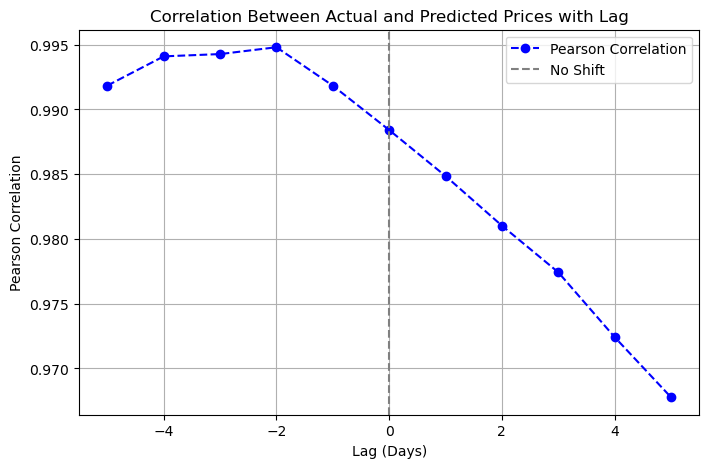

Best Lag: -2 days
The model might be predicting one step too early.


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr


actual_prices = np.array(actuals)  
predicted_prices = np.array(predictions)  

lags = range(-5, 6)  
correlations = []

for lag in lags:
    if lag == 0:
        shifted_actuals = actual_prices 
        shifted_predictions = predicted_prices
    elif lag < 0:
        shifted_actuals = actual_prices[:lag]  
        shifted_predictions = predicted_prices[-lag:]
    else:
        shifted_actuals = actual_prices[lag:]
        shifted_predictions = predicted_prices[:-lag]


    min_length = min(len(shifted_actuals), len(shifted_predictions))
    if min_length < 2:
        print(f"Skipping lag {lag} due to insufficient data (length = {min_length})")
        correlations.append(None) 
        continue

    shifted_actuals = shifted_actuals[:min_length]
    shifted_predictions = shifted_predictions[:min_length]

    correlation, _ = pearsonr(shifted_actuals, shifted_predictions)
    correlations.append(correlation)


correlations = [c if c is not None else np.nan for c in correlations]

# Plot correlation vs lag
plt.figure(figsize=(8, 5))
plt.plot(lags, correlations, marker='o', linestyle='--', color='b', label="Pearson Correlation")
plt.axvline(0, color='gray', linestyle='--', label='No Shift')
plt.xlabel("Lag (Days)")
plt.ylabel("Pearson Correlation")
plt.title("Correlation Between Actual and Predicted Prices with Lag")
plt.legend()
plt.grid(True)
plt.show()


valid_correlations = [c for c in correlations if not np.isnan(c)]
best_lag = lags[np.argmax(valid_correlations)] if valid_correlations else None

if best_lag is not None:
    print(f"Best Lag: {best_lag} days")
    if best_lag > 0:
        print("The model is lagging behind actual prices! It is reacting rather than predicting.")
    elif best_lag == 0:
        print("The model is predicting at the correct time step.")
    elif best_lag < 0:
        print("The model might be predicting one step too early.")
else:
    print("No valid correlations found.")


In [23]:
import numpy as np
from scipy.stats import pearsonr

# Convert lists to numpy arrays
actuals_array = np.array(actuals)
predictions_array = np.array(predictions)

# Shift actuals forward by 1 step
actuals_shifted = actuals_array[:-1]
predictions_aligned = predictions_array[1:]

# Compute Pearson correlation manually
manual_correlation = np.corrcoef(actuals_shifted, predictions_aligned)[0, 1]
scipy_correlation, _ = pearsonr(actuals_shifted, predictions_aligned)

print(f"Manual Pearson Correlation: {manual_correlation:.6f}")
print(f"Scipy Pearson Correlation: {scipy_correlation:.6f}")


Manual Pearson Correlation: 0.991837
Scipy Pearson Correlation: 0.991837


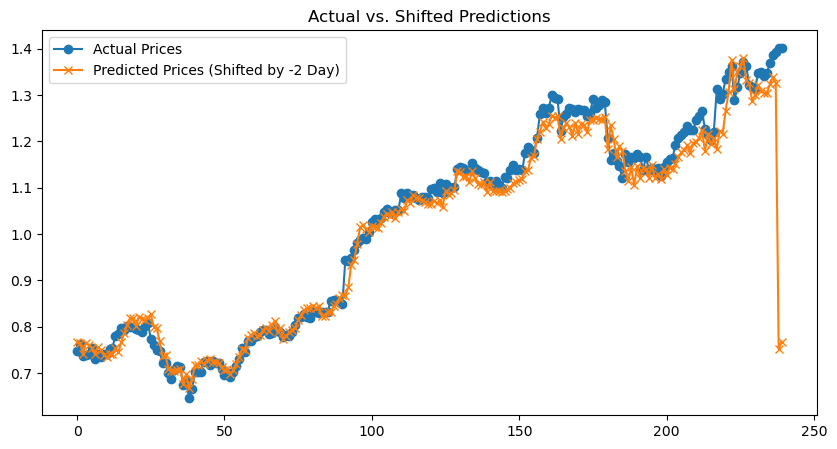

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(actuals_array, label="Actual Prices", marker="o")
plt.plot(np.roll(predictions_array, -2), label="Predicted Prices (Shifted by -2 Day)", marker="x")

plt.title("Actual vs. Shifted Predictions")
plt.legend()
plt.show()
